In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme(style="white")

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.cluster import KMeans, SpectralClustering

from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist
from scipy import stats
from sklearn.preprocessing import StandardScaler


from src.downsample import downsamp_audio
import src.dimension_reducer as dr
import src.distance_metrics as dm
import src.plotting as plotting
import src.emb_manipulator as em


from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

#Directory where already-generated embeddings stored
embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'

file = '03016_diarized_pyv2.csv'
emb = pd.read_csv(os.path.join(embedding_dir,file), index_col=0)
emb_down_unscaled = em.resample_data(emb,1)

#average emebdding for each participant
emb_a = em.embedding_averager(emb_down_unscaled)

#egemap (88 features) for each participant
gemap_file = '040122_segmented_postpartum_moms_gemaps_2sec.csv'
gemap_unscaled = pd.read_csv(os.path.join(embedding_dir,gemap_file), index_col=0)
gemap_unscaled = gemap_unscaled.drop(columns=['start','end'])


scaler = StandardScaler()
emb_down = pd.DataFrame(scaler.fit_transform(emb_down_unscaled.drop(columns='part_id')))
emb_down['part_id'] = emb_down_unscaled.part_id.to_numpy()

gemap = pd.DataFrame(scaler.fit_transform(gemap_unscaled.drop(columns='part_id')))
gemap['part_id'] = gemap_unscaled.part_id.to_numpy()

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
#default
#learning_rate = emb_down.shape[0]//12
#perplexity = 30

#n_neighbors = 10
#dist=0.1

#max global structure
#perplexity = 135
#learning_rate = 200

#n_neighbors=14
#dist=10E-3

#max local structure
perplexity = 15
learning_rate=200

n_neighbors=6
dist=10E-4

In [5]:
#Using tsne with perplexity=30 (default) since N/100<30, and learning rate of n/12. Random seed is 42 so the result is the same each time
emb_tsne = dr.run_tsne(emb_down, perplexity = perplexity, init='pca', learning_rate=learning_rate)

#run umap with default parameters
emb_umap = dr.run_umap(emb_down, n_neighbors=n_neighbors, dist=dist)

<AxesSubplot:>

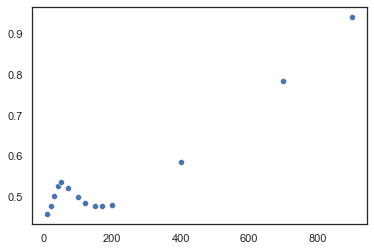

In [105]:
knn=[10, 20,np.sqrt(emb_down.shape[0]).astype(int),40, 50, 70, 100,120, 150,170,200,400,700, 900]

#we are always comparing to emb_down as our high-dimension embedding. 
high_dim = emb_down.drop(columns='part_id').to_numpy()
classes= emb_down.part_id.to_numpy() #extract the categories/labels

#compare tsne to embeddings
low_dim = emb_tsne.drop(columns='part_id').to_numpy()
knn_dist_tsne_sweep = [dm.embedding_quality(high_dim, low_dim, classes, knn=k, subsetsize=emb_down.shape[0])[0] for k in knn]
sns.scatterplot(x= knn, y= knn_dist_tsne_sweep)

<AxesSubplot:>

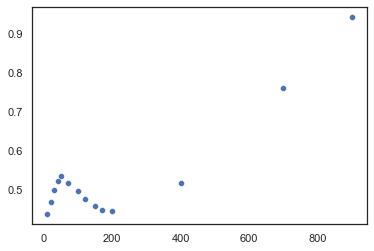

In [107]:
knn=[10, 20,np.sqrt(emb_down.shape[0]).astype(int),40, 50, 70, 100,120, 150,170,200,400,700, 900]

#we are always comparing to emb_down as our high-dimension embedding. 
high_dim = emb_down.drop(columns='part_id').to_numpy()
classes= emb_down.part_id.to_numpy() #extract the categories/labels

#compare tsne to embeddings
low_dim = emb_umap.drop(columns='part_id').to_numpy()
knn_dist_umap_sweep = [dm.embedding_quality(high_dim, low_dim, classes, knn=k, subsetsize=emb_down.shape[0])[0] for k in knn]
sns.scatterplot(x= knn, y= knn_dist_umap_sweep)

In [120]:
subsetsize = [100, 200, 300, 400, 500, 600, 700, 800, emb_down.shape[0]]

#we are always comparing to emb_down as our high-dimension embedding. 
high_dim = emb_down.drop(columns='part_id').to_numpy()
classes= emb_down.part_id.to_numpy() #extract the categories/labels

#compare tsne to embeddings
low_dim = emb_tsne.drop(columns='part_id').to_numpy()

cpd_dist_tsne_sweep = []
for i in np.arange(100):
    cpd_dist_tsne_sweep.append([dm.embedding_quality(high_dim, low_dim, classes, knn=50, subsetsize=s)[2] for s in subsetsize])


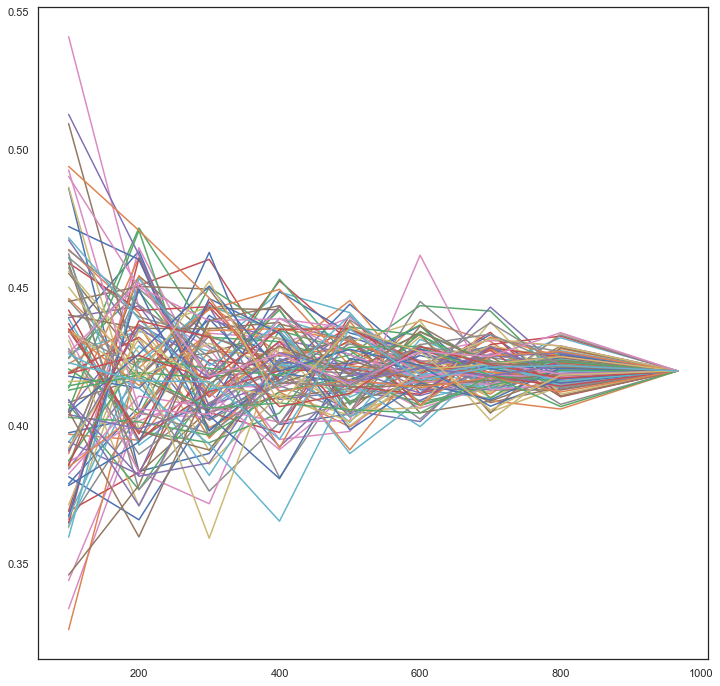

In [129]:
figure, ax = plt.subplots(1,figsize=(12,12))
[sns.lineplot(x=subsetsize, y= y)for y in np.vstack(cpd_dist_tsne_sweep)]
plt.show()

In [133]:
subsetsize = [100, 200, 300, 400, 500, 600, 700, 800, emb_down.shape[0]]

#we are always comparing to emb_down as our high-dimension embedding. 
high_dim = emb_down.drop(columns='part_id').to_numpy()
classes= emb_down.part_id.to_numpy() #extract the categories/labels

#compare tsne to embeddings
low_dim = emb_umap.drop(columns='part_id').to_numpy()

cpd_dist_umap_sweep = []
for i in np.arange(100):
    cpd_dist_umap_sweep.append([dm.embedding_quality(high_dim, low_dim, classes, knn=50, subsetsize=s)[2] for s in subsetsize])

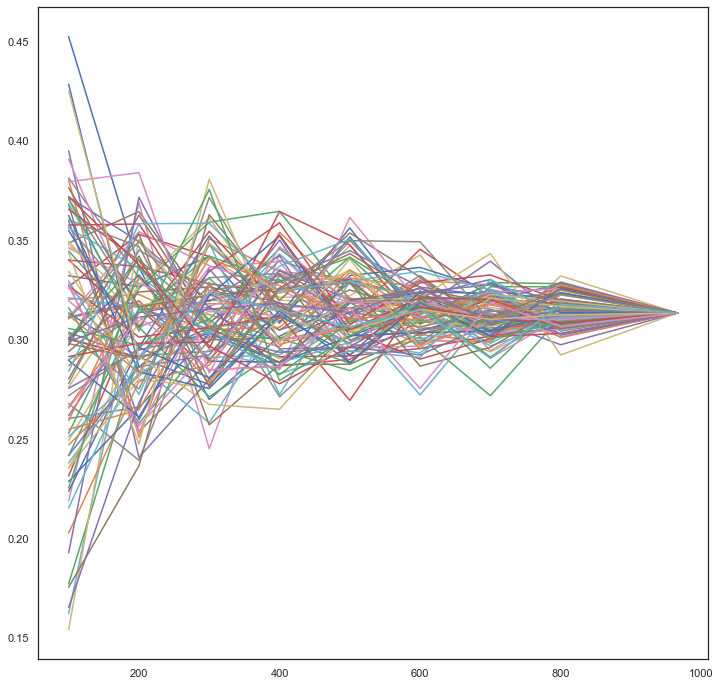

In [134]:
figure, ax = plt.subplots(1,figsize=(12,12))
[sns.lineplot(x=subsetsize, y= y)for y in np.vstack(cpd_dist_umap_sweep)]
plt.show()

<AxesSubplot:>

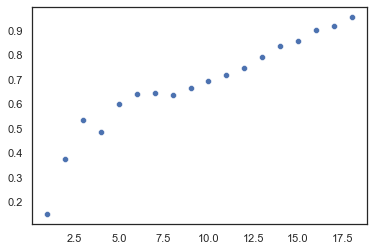

In [14]:
knn_classes= list(np.arange(18)+1)

#we are always comparing to emb_down as our high-dimension embedding. 
high_dim = emb_down.drop(columns='part_id').to_numpy()
classes= emb_down.part_id.to_numpy() #extract the categories/labels

#compare tsne to embeddings
low_dim = emb_tsne.drop(columns='part_id').to_numpy()
knc_dist_tsne_sweep = [dm.embedding_quality(high_dim, low_dim, classes, knn=50, knn_classes=knc, subsetsize=700)[1] for knc in knn_classes]
sns.scatterplot(x= knn_classes, y= knc_dist_tsne_sweep)